In [1]:
import os
from random import shuffle

import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
from torch import nn
from glob import glob
import os
import numpy as np
import torch
from PIL import Image
import pandas as pd

import albumentations as A

/home/anelmusic/anaconda3/envs/ml/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Preparation:
The class_dict_seg.csv contains the rgb color for each class that can be used to convert color to label and vice versa. 

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
label_file_path = 'semantic-drone-dataset/class_dict_seg.csv'
labels_df = pd.read_csv(label_file_path)
labels_df

,name,r,g,b
0,unlabeled,0,0,0
1,paved-area,128,64,128
2,dirt,130,76,0
3,grass,0,102,0
4,gravel,112,103,87
5,water,28,42,168
6,rocks,48,41,30
7,pool,0,50,89
8,vegetation,107,142,35
9,roof,70,70,70


We can convert the labels_df to dict as this is more convenient to use.

In [4]:
# Function creates dict from dataframe
def label_df_to_dict(label_df):
    return {row['name']: [row[' r'], row[' g'], row[' b']] for index, row in labels_df.iterrows()}

In [5]:
classname_to_rgb_mapping = label_df_to_dict(labels_df)
class_names = list(classname_to_rgb_mapping.keys())


Set path to image dir and mask dir:

In [6]:
dataset_path = "semantic-drone-dataset"
img_path = dataset_path + '/dataset/semantic_drone_dataset/original_images/'
mask_path = dataset_path + '/RGB_color_image_masks/RGB_color_image_masks/'

In [7]:
img_paths = sorted(glob(img_path + '*.jpg'))
mask_paths = sorted(glob(mask_path + '*.png'))
assert len(img_paths) == len(mask_paths)

In [8]:
len(img_paths), len(mask_paths)

(400, 400)

Resizing images during runtime using augmentation takes too long. Therefore we'll resize the dataset and overwrite the original files:

In [9]:

RESIZE = False
resized_height = 400
resized_width = 600

if RESIZE:
    for i in range(len(img_paths)):
        img = Image.open(img_paths[i]).convert('RGB') 
        mask = Image.open(mask_paths[i]).convert('RGB') 

        img = img.resize((resized_width, resized_height))    
        mask = mask.resize((resized_width, resized_height))
        img.save(img_paths[i])    
        mask.save(mask_paths[i])


In [10]:

# Convert 3D rgb color to 1D mask idx
def rgb_to_mask(source_rgb_mask, classname_to_rgb_mapping, class_names):
    source_rgb_mask = np.array(source_rgb_mask)
    height, width, channels = source_rgb_mask.shape
    cls_mask = np.ones(source_rgb_mask.shape, dtype=np.uint8) 
    
    for classname in classname_to_rgb_mapping:
        current_cls_mask = source_rgb_mask ==  classname_to_rgb_mapping[classname]   
        current_cls_mask = current_cls_mask.all(axis=2) 
        cls_mask[current_cls_mask] = class_names.index(classname)
        
    cls_mask = cls_mask[:,:,0]  
    cls_mask = np.reshape(cls_mask, (height, width, 1)) 
                                                          
    return  cls_mask
    
    
# Convert 1D msk idx to 3D rgb color    
def convert_mask_to_rgb(predicted_mask, classname_to_rgb_mapping, class_names):
    rgb_img = np.stack([predicted_mask, predicted_mask, predicted_mask], axis = 2).astype(int)
    rgb_img = rgb_img.squeeze()
    height, width, channels = predicted_mask.shape
    rgb_img = rgb_img.reshape([height*width, 3])
    
    for pixel_idx, pixel_rgb_vals in enumerate(rgb_img):
        rgb_img[pixel_idx] = classname_to_rgb_mapping[class_names[pixel_rgb_vals[0]]]
        
    rgb_img = rgb_img.reshape([height, width,  3])

    return rgb_img

In [11]:
def convert_mask_to_rgb(predicted_mask, classname_to_rgb_mapping, class_names):
    rgb_img = np.stack([predicted_mask, predicted_mask, predicted_mask], axis = 2).astype(int)
    rgb_img = rgb_img.squeeze()
    height, width, channels = predicted_mask.shape
    rgb_img = rgb_img.reshape([height*width, 3])
    
    for pixel_idx, pixel_rgb_vals in enumerate(rgb_img):
        rgb_img[pixel_idx] = classname_to_rgb_mapping[class_names[pixel_rgb_vals[0]]]
        
    rgb_img = rgb_img.reshape([height, width,  3])

    return rgb_img

In [12]:
mask = Image.open(mask_paths[300]).convert("RGB")
img = Image.open(img_paths[300]).convert("RGB")

mask = np.array(mask) # convert the PIL Image into a numpy array
img = np.array(img)

print(img.shape)


(400, 600, 3)


In [13]:
target_height = 512
target_width = 512

In [14]:
training_transform = A.Compose(
    [   
        A.Resize(target_height, target_width,p=1),   
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.25),
        A.OpticalDistortion(distort_limit=0.25, shift_limit=0.25, p=1),     
    ]
)

inference_transform = A.Compose(
    [
        A.Resize(target_height, target_width, p=1)
    ]
)

In [15]:
def plot_examples(images, bboxes=None):
    fig = plt.figure(figsize=(15, 15))
    columns = 4
    rows = 4

    for i in range(1, len(images)):
        img = images[i-1]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
    plt.show()

def show_transformation_examples(image, mask, transform):
    image = np.array(img)
    mask = np.array(mask) 
    augmented_imgs =  []
    augmented_masks =  []

    for i in range(9):
        augmentations = transform(image=image, masks=[mask])
        augmented_imgs.append(augmentations["image"])
        augmented_masks.append(augmentations["masks"][0])
    
    plot_examples(augmented_imgs)
    plot_examples(augmented_masks)

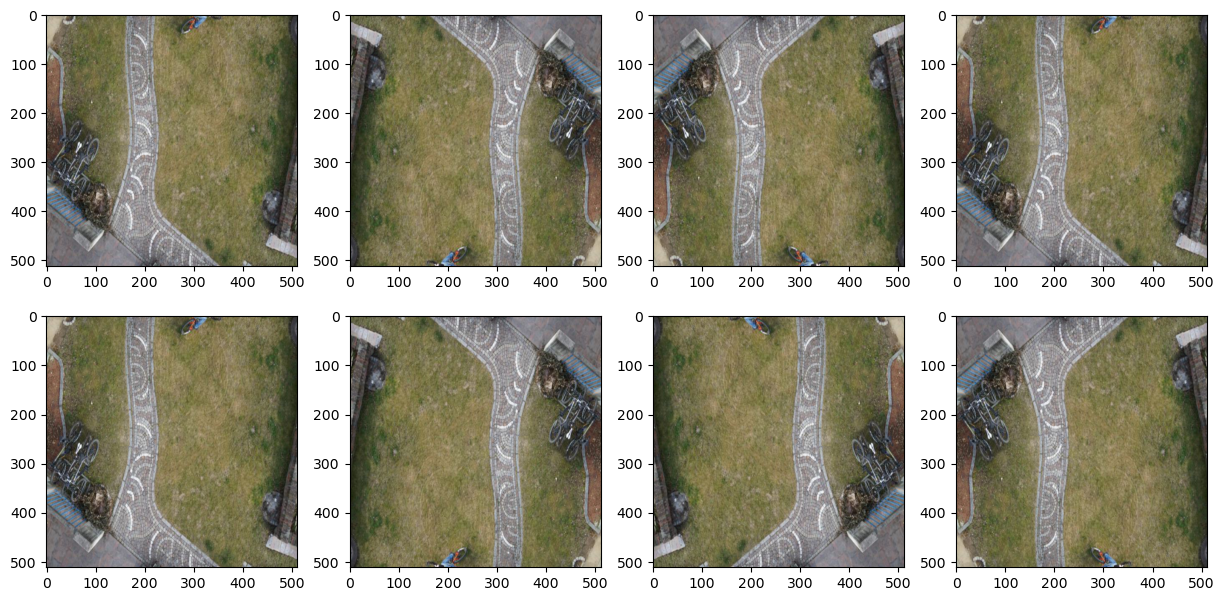

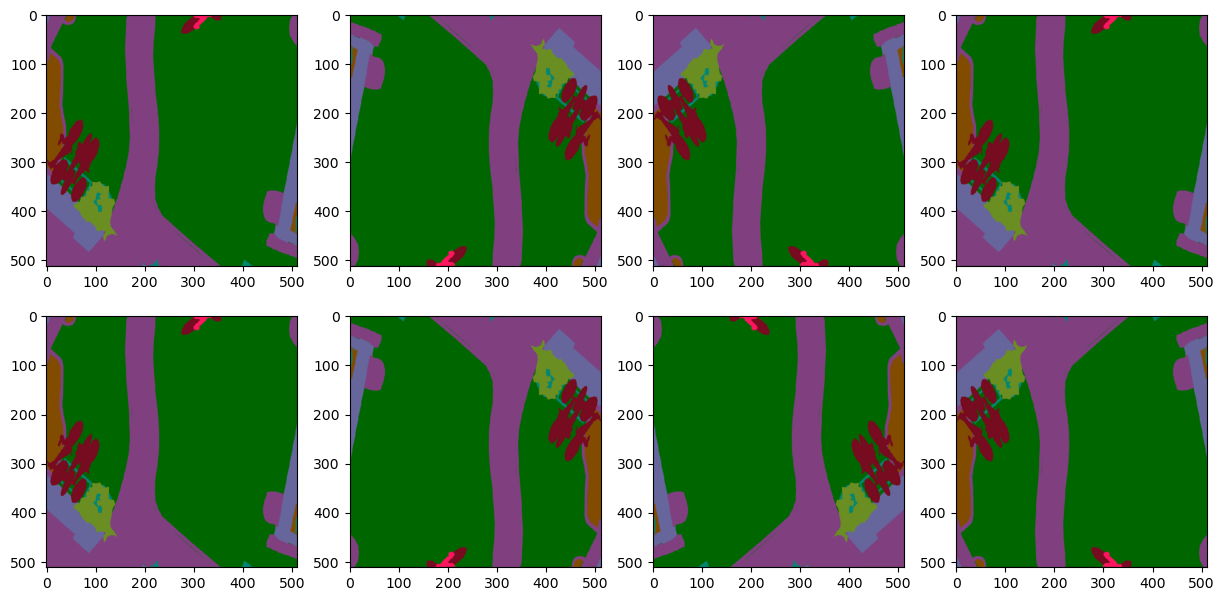

In [16]:
# You can test different transoformations by running this cell
transform = A.Compose(
    [
        A.Resize(target_height, target_width,p=1),   
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.25),
        #A.RandomBrightnessContrast(p=0.25),
        #A.GaussNoise(),
    ]
)
image = np.array(img)
mask = np.array(mask) 

show_transformation_examples(image, mask, transform)


Prepare Dataset Class

In [17]:
class AerialDroneDataset(torch.utils.data.Dataset):
    def __init__(self, img_path, mask_path, training, classname_to_rgb_mapping, class_names, inference_transform, training_transform):
        super(AerialDroneDataset, self).__init__()
        self.img_path = img_path
        self.mask_path = mask_path
        self.training = training
        self.inference_transform = inference_transform 
        self.training_transform = training_transform
        self.img_paths = sorted(glob(self.img_path + '*.jpg'))
        self.mask_paths = sorted(glob(self.mask_path + '*.png'))
        self.classname_to_rgb_mapping = classname_to_rgb_mapping
        self.class_names = class_names
        
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        mask_path = self.mask_paths[idx]
        image = Image.open(img_path).convert('RGB') 
        mask = Image.open(mask_path).convert('RGB') # needs 3c->1c conversion to
        
        image = np.array(image)
        mask = np.array(mask)
        mask = rgb_to_mask(mask, self.classname_to_rgb_mapping, self.class_names)        

        if self.training==True:
            augmentations = self.training_transform(image=image, masks=[mask])
            image = augmentations["image"]
            mask= augmentations["masks"][0]
        else:
            augmentations = self.inference_transform(image=image, masks=[mask])
            image = augmentations["image"]
            mask= augmentations["masks"][0]
        
        # normalize img but not mask
        image = image/255
        height = image.shape[0]
        width = image.shape[1]        
        image, mask = torch.tensor(image).float(), torch.tensor(mask, dtype=torch.int64)
        image = torch.reshape(image, (3, height, width)) # Reshape for Seg Models
        mask = torch.reshape(mask, (1, height, width))
        
        return image, mask


    def __len__(self):
        return len(self.img_paths)
    
    
    
dataset = AerialDroneDataset(img_path, mask_path, True, classname_to_rgb_mapping, class_names, training_transform, inference_transform)


In [18]:
# Plausibility Check:
for a in iter(dataset):
    print(a[0].shape)
    print(a[1].shape)
    print(1)
    break

torch.Size([3, 512, 512])
torch.Size([1, 512, 512])
1


In [19]:
# Create Model:
from torchvision.models.segmentation import deeplabv3_resnet101, DeepLabV3_ResNet101_Weights

weights = DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1
model = deeplabv3_resnet101(weights, progress=True)


for param in model.parameters():
    param.requires_grad = True

# Same as before just change out_channels
model.classifier[4] = nn.Conv2d(model.classifier[-1].in_channels, len(class_names), 1, 1)

model = model.to(device)

criterion = nn.CrossEntropyLoss() 
test_num = int(0.8 * len(dataset))

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset)-test_num, test_num], generator=torch.Generator().manual_seed(101))
BACH_SIZE = 4
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BACH_SIZE, shuffle=True, num_workers=0)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BACH_SIZE, shuffle=False, num_workers=0)

/home/anelmusic/anaconda3/envs/ml/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [20]:
def train_model(model, train_dataloader, test_dataloader, epochs, criterion, optimizer):
    model.to(device)
    print("Using Device: ", device)

    for epoch in range(epochs):
        # training
        print(f'Current epoch: {epoch+1}')

        loss_list = []
        acc_list = []
        
        for batch_i, data in enumerate(train_dataloader):
            model.train()

            x,y = data[0].to(device), data[1].to(device) # x = bs, c, height, widhth
            
            pred_mask = model(x)  
            pred_mask = pred_mask['out'] # model creates dict out and aux we need out 
            
            bs,channels, height, width = y.shape
            #print("y before = ", y.shape) # we expect bs, imheight, imwidth but  we got bs, 1, imheight, imwidth
            y = y.view(bs,height, width)
            loss = criterion(pred_mask, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        # validation
        model.eval()
        for batch_i, data in enumerate(test_dataloader):
            x,y = data[0].to(device), data[1].to(device)
            bs,channels, height, width = y.shape
            y = y.view(bs,height, width)

            with torch.no_grad():    
                pred_mask = model(x)  
                pred_mask = pred_mask['out']
            val_loss = criterion(pred_mask, y)
    return model

In [21]:
model = train_model(model, train_dataloader, test_dataloader, 100, criterion, optimizer)

Using Device:  cuda
Current epoch: 1
Current epoch: 2
Current epoch: 3
Current epoch: 4
Current epoch: 5
Current epoch: 6
Current epoch: 7
Current epoch: 8
Current epoch: 9
Current epoch: 10
Current epoch: 11
Current epoch: 12
Current epoch: 13
Current epoch: 14
Current epoch: 15
Current epoch: 16
Current epoch: 17
Current epoch: 18
Current epoch: 19
Current epoch: 20
Current epoch: 21
Current epoch: 22
Current epoch: 23
Current epoch: 24
Current epoch: 25
Current epoch: 26
Current epoch: 27
Current epoch: 28
Current epoch: 29
Current epoch: 30
Current epoch: 31
Current epoch: 32
Current epoch: 33
Current epoch: 34
Current epoch: 35
Current epoch: 36
Current epoch: 37
Current epoch: 38
Current epoch: 39
Current epoch: 40
Current epoch: 41
Current epoch: 42
Current epoch: 43
Current epoch: 44
Current epoch: 45
Current epoch: 46
Current epoch: 47
Current epoch: 48
Current epoch: 49
Current epoch: 50
Current epoch: 51
Current epoch: 52
Current epoch: 53
Current epoch: 54
Current epoch: 55

In [54]:
def plot_model_inference_results(model, data_loader, num_examples, target_height, target_width, classname_to_rgb_mapping, class_names, batch_size):
    model = model.cpu()
    
    if num_examples > batch_size:
        num_examples = batch_size

    for batch_i, (x, y) in enumerate(data_loader):
        for j in range(num_examples):
            result = model(x[j:j+1])['out']
            mask = torch.argmax(result, axis=1).cpu().detach().numpy()[0]
            mask = np.expand_dims(mask, -1)
            
            im = x[j].cpu().detach()
            im = im.view(target_height, target_width, 3)
            
            gt_mask = y[j].cpu().detach()
            gt_mask = gt_mask.view(target_height, target_width, 1)

            plt.figure(figsize=(12,12))
            plt.subplot(1,3,1)
            plt.imshow(im)

            plt.subplot(1,3,2)
            plt.imshow(convert_mask_to_rgb(gt_mask, classname_to_rgb_mapping, class_names))
            plt.subplot(1,3,3)
            plt.imshow(convert_mask_to_rgb(mask, classname_to_rgb_mapping, class_names))
            plt.show()
        break

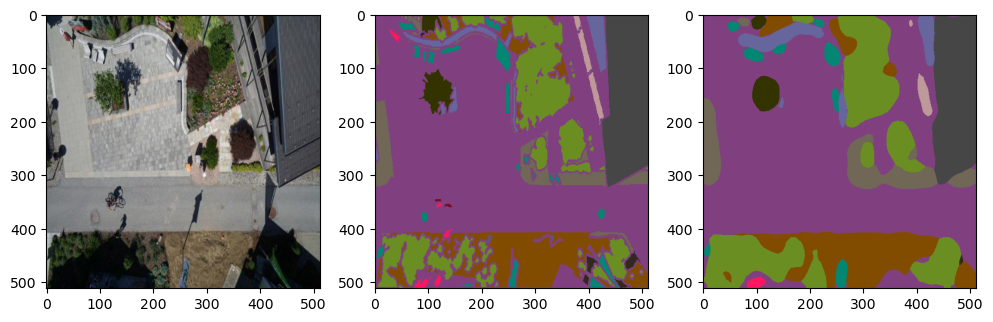

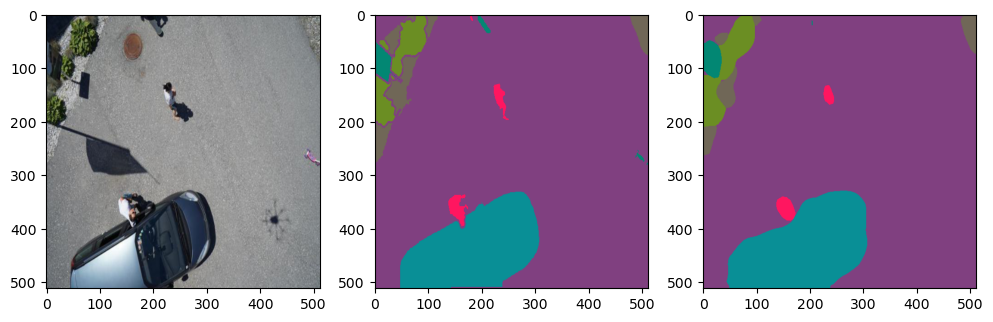

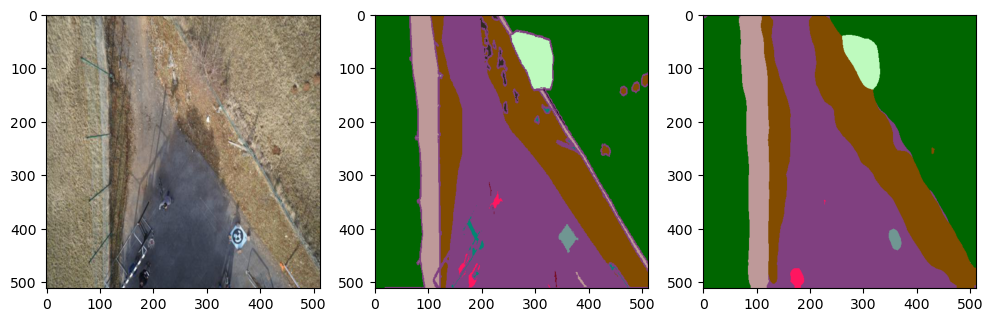

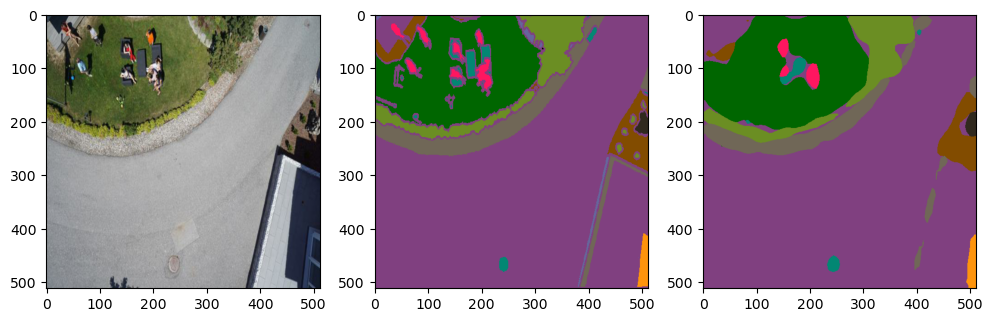

In [23]:
plot_model_inference_results(model, 10, target_height, target_width, classname_to_rgb_mapping, class_names, batch_size=BACH_SIZE)